In [1]:
!nvidia-smi

Fri Sep 29 08:03:35 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K40m          Off  | 0000:28:00.0     Off |                    0 |
| N/A   22C    P8    20W / 235W |      2MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K40m          Off  | 0000:2B:00.0     Off |                    0 |
| N/A   33C    P0    58W / 235W |      2MiB / 11439MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [2]:
#from __future__ import print_function
#from __future__ import absolute_import
#from __future__ import division


import torch 
import torch.nn as nn
from torch.autograd import Variable
import torchvision.datasets as dataset
import visdom
import sys,argparse,os

from models import scribbler, discriminator
import torch.optim as optim

from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
import visualize
import torch.nn as nn
from torch.autograd import Variable
from IPython.display import display
import torchvision.models as models
from dataloader import imfol

from utils.visualize import vis_patch, vis_image
        
from torch.utils.data import DataLoader
from dataloader.imfol import ImageFolder, make_dataset
from utils import transforms as custom_trans
import torchvision.transforms as tforms
import utils.transforms as utforms

from networks import define_G, weights_init
from models import scribbler_dilate_128 
import visdom

In [3]:
def clamp_image(img):
    img[:,0,:,:].clamp_(0,1)
    img[:,1,:,:].clamp_(-1.5,1.5)
    img[:,2,:,:].clamp_(-1.5,1.5)
    return img    

In [121]:
def parse_arguments(argv):
    parser = argparse.ArgumentParser()
    
###############added options#######################################
    parser.add_argument('-learning_rate', default=1e-3, type=float,
                    help='Learning rate for the generator')
    parser.add_argument('-learning_rate_D',  default=1e-4,type=float,
                    help='Learning rate for the discriminator')    
    
    parser.add_argument('-gan', default='lsgan',type=str,choices=['dcgan', 'lsgan'],
                    help='dcgan|lsgan') #todo wgan/improved wgan    
    
    parser.add_argument('-model', default='pix2pix',type=str,choices=['scribbler', 'pix2pix'],
                   help='scribbler|pix2pix')
    
    parser.add_argument('-num_epoch',  default=1,type=int,
                    help='texture|scribbler')   
    
    parser.add_argument('-visualize_every',  default=10,type=int,
                    help='no. iteration to visualize the results')      

    #all the weights ratio, might wanna make them sum to one
    parser.add_argument('-feature_weight', default=100,type=float,
                       help='weight ratio for feature loss')
    parser.add_argument('-pixel_weight_l', default=100,type=float,
                       help='weight ratio for pixel loss for l channel')
    parser.add_argument('-pixel_weight_ab', default=500,type=float,
                   help='weight ratio for pixel loss for ab channel')
    parser.add_argument('-pixel_weight_rgb', default=0,type=float,
                   help='weight ratio for pixel loss for ab channel')
    
    parser.add_argument('-discriminator_weight', default=0,type=float,
                   help='weight ratio for the discriminator loss')
    parser.add_argument('-style_weight', default = 0, type=float, 
                        help='weight ratio for the texture loss')


    parser.add_argument('-gpu', default=1,type=int,
                   help='id of gpu to use') #TODO support cpu

    parser.add_argument('-display_port', default=7779,type=int,
               help='port for displaying on visdom (need to match with visdom currently open port)')

    parser.add_argument('-data_path', default='/home/psangkloy3/training_catdog/',type=str,
                   help='path to the data directory, expect train_skg, train_img, val_skg, val_img')

    parser.add_argument('-save_dir', default='/home/psangkloy3/texturegan/catdog_scribbler/',type=str,
                   help='path to save the model')
    
    parser.add_argument('-load_dir', default='/home/psangkloy3/texturegan/catdog/',type=str,
                   help='path to save the model')
    
    parser.add_argument('-save_every',  default=1000,type=int,
                    help='no. iteration to save the models')
    
    parser.add_argument('-load', default=14000,type=int,
                   help='load generator and discrminator from iteration n')
    parser.add_argument('-load_D', default=7000,type=float,
                   help='load discriminator from iteration n, priority over load')
    
    parser.add_argument('-image_size',default=128,type=int,
                    help='Training images size, after cropping')        
    parser.add_argument('-resize_max',  default=1,type=int,
                    help='max resize, ratio of the original image, max value is 1')        
    parser.add_argument('-resize_min',  default=0.8,type=int,
                    help='min resize, ratio of the original image, min value 0')   
    parser.add_argument('-crop_size_min',default=50,type=int,
                    help='minumum texture patch size')   
    parser.add_argument('-crop_size_max',default=70,type=int,
                    help='max texture patch size')  
    
    parser.add_argument('-batch_size', default=8)     
    
    parser.add_argument('-local_texture_size', default=50,type=int,
                   help='use local texture loss instead of global, set -1 to use global')
    parser.add_argument('-color_space',  default='lab',type=str,choices=['lab','rgb'],
                help='lab|rgb') 
    
############################################################################
############################################################################
############TODO: TO ADD#################################################################
    parser.add_argument('-tv_weight', default=1,type=float,
                   help='weight ratio for total variation loss')
    parser.add_argument('-content_layers',  default='relu2_2',type=str,
                    help='Layer to attach content loss.')
    


    
    parser.add_argument('-mode',  default='texture',type=str,choices=['texture','scribbler'],
                    help='texture|scribbler') 
    
   
    parser.add_argument('-crop',  default='random',type=str,choices=['random','center'],
                    help='random|center')
    
    parser.add_argument('-contrast',  default=True,type=bool,
                    help='randomly adjusting contrast on sketch')
    
    parser.add_argument('-occlude', default=False,type=bool,
                       help='randomly occlude part of the sketch')
    
    
    parser.add_argument('-checkpoints_path', default='data/',type=str,
                   help='output directory for results and models')
    

    
    parser.add_argument('-noise_gen', default=False,type=bool,
                   help='whether or not to inject noise into the network')
    
    
    parser.add_argument('-absolute_load', default='',type=str,
                   help='load saved generator model from absolute location')
    
    
    
    
##################################################################################################################################    
    
    return parser.parse_args(argv)

In [122]:
#all in one place funcs, need to organize these:
def rand_between(a,b):
    return a + torch.round(torch.rand(1)*(b-a))[0]

def gen_input(img,skg,xcenter=64,ycenter=64,size=40):
    #generate input skg with random patch from img
    #input img,skg [bsx3xwxh], xcenter,ycenter, size 
    #output bsx5xwxh
       
    w,h = img.size()[2:4]

    xstart = max(xcenter-size/2,0)
    ystart = max(ycenter-size/2,0)
    xend = min(xcenter + size/2,w)
    yend = min(ycenter + size/2,h)


    input_texture = torch.ones(img.size())*(1)
    input_sketch = skg[:,0:1,:,:] #L channel from skg
    input_mask = torch.ones(input_sketch.size())*(-1)

    input_mask[:,:,xstart:xend,ystart:yend] = 1
    input_texture[:,:,xstart:xend,ystart:yend] = img[:,:,xstart:xend,ystart:yend].clone()

    return torch.cat((input_sketch.float(),input_texture.float(),input_mask),1)
     
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a , b, c * d)  # resise F_XL into \hat F_XL

        G = torch.bmm(features, features.transpose(1,2))  # compute the gram product

        # normalize the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div( b * c * d)
    
class FeatureExtractor(nn.Module):
    # Extract features from intermediate layers of a network

    def __init__(self, submodule, extracted_layers):
        super(FeatureExtractor,self).__init__()
        self.submodule = submodule
        self.extracted_layers=extracted_layers

    def forward(self, x):
        outputs = []
        for name, module in self.submodule._modules.items():
            x = module(x)
            if name in self.extracted_layers:
                outputs += [x]
        return outputs + [x]
    
def save_network(model, network_label, epoch_label, gpu_id, save_dir):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, save_filename)
    torch.save(model.cpu().state_dict(), save_path)
    model.cuda(device_id=gpu_id)
def load_network(model, network_label, epoch_label,save_dir):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    save_path = os.path.join(save_dir, save_filename)
    model.load_state_dict(torch.load(save_path))

In [123]:
command = '-content_layers relu2_2 -feature_weight 100 -pixel_weight_ab 1 -tv_weight 0.0001 -model scribbler_custom -data_path /home/psangkloy3/training_handbag_pretrain/ -gpu 1 -display_port 7779 -image_size 128 -save_every 5000 -visualize_every 10 -discriminator_weight 0 -learning_rate 1e-3 -learning_rate_D 1e-6 -batch_size 6 -contrast True -resize_max 256 -resize_min 128 -gan lsgan -load 100000'
command = ''
args = parse_arguments(command.split())

In [ ]:
#TODO: visdom show the whole batch and on test set
#TODO: index to name mapping for vgg layers
#TODO: rgb/lab option

with torch.cuda.device(args.gpu):
    
    vis=visdom.Visdom(port=args.display_port)
    
    Loss_g_graph=[]
    Loss_gd_graph=[]
    Loss_gf_graph = []
    Loss_gpl_graph = []
    Loss_gpab_graph = []    
    Loss_gs_graph = []
    Loss_d_graph=[]
    #for rgb the change is to feed 3 channels to D instead of just 1. and feed 3 channels to vgg. 
    #can leave pixel separate between r and gb for now. assume user use the same weights
    if args.color_space == 'lab':
        ts=custom_trans.Compose([custom_trans.RandomSizedCrop(args.image_size,args.resize_min,args.resize_max),
                                 custom_trans.RandomHorizontalFlip() ,custom_trans.toLAB(), custom_trans.toTensor()])
    elif args.color_space == 'rgb':
        ts=custom_trans.Compose([custom_trans.RandomSizedCrop(args.image_size,args.resize_min,args.resize_max),
                                 custom_trans.RandomHorizontalFlip() ,custom_trans.toRGB('RGB'), custom_trans.toTensor()])
        args.pixel_weight_ab = args.pixel_weight_rgb
        args.pixel_weight_l = args.pixel_weight_rgb
    rgbify = custom_trans.toRGB()
    dset = ImageFolder(args.data_path,ts)
    dataloader=DataLoader(dataset=dset, batch_size=args.batch_size, shuffle=True)
    
   # renormalize = transforms.Normalize(mean=[+0.5+0.485, +0.5+0.456, +0.5+0.406], std=[0.229, 0.224, 0.225])
    
    sigmoid_flag = 1
    if args.gan =='lsgan':
        sigmoid_flag = 0 
        
    if args.model=='scribbler':
        netG=scribbler_dilate_128.ScribblerDilate128(5,3,32)
    elif args.model=='pix2pix':
        netG=define_G(5,3,32)
    else:
        print(args.model+ ' not support. Using pix2pix model')
        netG=define_G(5,3,32)
    if args.color_space =='lab':
        netD=discriminator.Discriminator(1,32,sigmoid_flag) 
    elif args.color_space =='rgb':
        netD=discriminator.Discriminator(3,32,sigmoid_flag) 
    feat_model=models.vgg19(pretrained=True)
    if args.load == -1:
        netG.apply(weights_init)
    else:
        
        load_network(netG,'G',args.load,args.load_dir)
        print('Loaded G from itr:' + str(args.load))
    if args.load_D == -1:
        netD.apply(weights_init)  
    else:
        load_network(netD,'D',args.load_D,args.load_dir)
        print('Loaded D from itr:' + str(args.load_D))
    
    if args.gan =='lsgan':
        criterion_gan = nn.MSELoss()
    elif args.gan =='dcgan':
        criterion_gan = nn.BCELoss()
        
    #criterion_l1 = nn.L1Loss()
    criterion_pixel_l = nn.L1Loss()
    criterion_pixel_ab = nn.L1Loss()
    criterion_style = nn.L1Loss()
    criterion_feat = nn.L1Loss()

    input_stack = torch.FloatTensor()
    target_img = torch.FloatTensor()
    segment = torch.FloatTensor()
    
    
    label = torch.FloatTensor(args.batch_size)
    real_label = 1
    fake_label = 0

    optimizerD = optim.Adam(netD.parameters(), lr=args.learning_rate_D, betas=(0.5, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=args.learning_rate, betas=(0.5, 0.999))

    netG.cuda()
    netD.cuda()
    feat_model.cuda()
    criterion_gan.cuda()
    criterion_pixel_l.cuda()
    criterion_pixel_ab.cuda()
    criterion_feat.cuda()
    input_stack, target_img, segment, label = input_stack.cuda(), target_img.cuda(),segment.cuda(), label.cuda()

    Extract_content = FeatureExtractor(feat_model.features, ['11'])
    Extract_style = FeatureExtractor(feat_model.features, ['0','5','10','19','28'])
    for epoch in range(args.num_epoch):
        for i, data in enumerate(dataloader, 0):
            
            
            #Detach is apparently just creating new Variable with cut off reference to previous node, so shouldn't effect the original 
            #But just in case, let's do G first so that detaching G during D update don't do anything weird
            ############################
            # (1) Update G network: maximize log(D(G(z)))
            ###########################
            netG.zero_grad()
            
            img, skg,seg = data #LAB with negeative value
            
            #output img/skg/seg rgb between 0-1
            #output img/skg/seg lab between 0-100, -128-128 
            if args.color_space =='lab':
                img=utforms.normalize_lab(img)
                skg=utforms.normalize_lab(skg)
            elif args.color_space =='rgb':
                img=utforms.normalize_rgb(img)
                skg=utforms.normalize_rgb(skg)  
            
            #skg = torch.round(skg)
           # break
            #randomize patch position/size
            crop_size = int( rand_between(args.crop_size_min, args.crop_size_max))
            xcenter = int( rand_between(crop_size/2,args.image_size-crop_size/2))
            ycenter = int( rand_between(crop_size/2,args.image_size-crop_size/2))
            inp = gen_input(img,skg,xcenter,ycenter,crop_size)
            
            
            img=img.cuda()
            skg=skg.cuda()
            seg=seg.cuda()
            
            inp = inp.cuda()
            
            input_stack.resize_as_(inp.float()).copy_(inp)
            target_img.resize_as_(img.float()).copy_(img)
            segment.resize_as_(seg.float()).copy_(seg)
            
            inputv = Variable(input_stack)
            targetv = Variable(target_img)
            
            outputG = netG(inputv)
            
            outputl,outputa,outputb=torch.chunk((outputG),3,dim=1)
            
            targetl,targeta,targetb = torch.chunk(targetv,3,dim=1)
            outputab = torch.cat((outputa,outputb),1)
            targetab = torch.cat((targeta,targetb),1)
            
            #TODO renormalize with the right mean (but shouldn't matter much, it's around 0.5 anyway)
            if args.color_space =='lab':
                outputlll= (torch.cat((outputl,outputl,outputl),1))
                targetlll = (torch.cat((targetl,targetl,targetl),1))
            elif args.color_space =='rgb':
                outputlll= outputG#(torch.cat((outputl,outputl,outputl),1))
                targetlll = targetv#(torch.cat((targetl,targetl,targetl),1))                
            
            ##################Pixel L Loss############################
            err_pixel_l = args.pixel_weight_l*criterion_pixel_l(outputl,targetl)
            
            ##################Pixel ab Loss############################
            err_pixel_ab = args.pixel_weight_ab*criterion_pixel_ab(outputab,targetab)
            
            
            ##################feature Loss############################
            out_feat = Extract_content(outputlll)[0]
            
            gt_feat = Extract_content(targetlll)[0]
            err_feat = args.feature_weight*criterion_feat(out_feat,gt_feat.detach())   
            
            
            ##################style Loss############################

            
            if args.local_texture_size == -1: #global
                output_feat_ = Extract_style(outputlll)
                target_feat_ = Extract_style(targetlll)
            else:
                patchsize = args.local_texture_size
                x = int( rand_between(patchsize,args.image_size-patchsize))
                y = int( rand_between(patchsize,args.image_size-patchsize))

                texture_patch = outputlll[:,:,x:(x+patchsize),y:(y+patchsize)]
                gt_texture_patch = targetlll[:,:,x:(x+patchsize),y:(y+patchsize)]
                output_feat_ = Extract_style(texture_patch)
                target_feat_ = Extract_style(gt_texture_patch)
                
                
            
            
            gram = GramMatrix()
            
            err_style = 0
            for m in range(len(output_feat_)): 
                gram_y = gram(output_feat_[m])
                gram_s = gram(target_feat_[m])
                
                err_style += args.style_weight * criterion_style(gram_y, gram_s.detach())
                  
           
            
            ##################D Loss############################
            netD.zero_grad()
            label_ = Variable(label)
            if args.color_space =='lab':
                outputD = netD(outputl)
            elif args.color_space =='rgb':
                outputD = netD(outputG)
            #D_G_z2 = outputD.data.mean()
            
            label.resize_(outputD.data.size())
            labelv = Variable(label.fill_(real_label))

            err_gan = args.discriminator_weight*criterion_gan(outputD, labelv)
            
            ####################################
            err_G = err_pixel_l+err_pixel_ab + err_gan + err_feat + err_style
            err_G.backward()
            
            optimizerG.step() 

            Loss_g_graph.append(err_G.data[0])
            Loss_gpl_graph.append(err_pixel_l.data[0])
            Loss_gpab_graph.append(err_pixel_ab.data[0])
            Loss_gd_graph.append(err_gan.data[0])
            Loss_gf_graph.append(err_feat.data[0])
            Loss_gs_graph.append(err_style.data[0])
            #plt.imshow(vis_image(inputv.data.double().cpu()))

            print i, err_G.data[0]            
            
            
            ############################
            # (2) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            # train with real
            netD.zero_grad()

            labelv = Variable(label)
            if args.color_space =='lab':
                outputD = netD(targetl)
            elif args.color_space =='rgb':
                outputD = netD(targetv)
                
            label.resize_(outputD.data.size())
            labelv = Variable(label.fill_(real_label))
            
            errD_real = criterion_gan(outputD, labelv)
            errD_real.backward()
            
            #D_x = output_.data.mean()

            # train with fake
            #noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
            #noisev = Variable(noise)
            
            ##################################
            #TODO add threshold to stop updating D
            if args.color_space =='lab':
                outputD = netD(outputl.detach())
            elif args.color_space =='rgb':
                outputD = netD(outputG.detach())
            label.resize_(outputD.data.size())
            labelv = Variable(label.fill_(fake_label))

            errD_fake = criterion_gan(outputD, labelv)
            errD_fake.backward()
            #D_G_z1 = output.data.mean()
            errD = errD_real + errD_fake
            Loss_d_graph.append(errD.data[0])
            optimizerD.step()
            #TODO add discriminator accuracy

            if(i%args.save_every==0):
                save_network(netG,'G',i,args.gpu,args.save_dir)
                save_network(netD,'D',i,args.gpu,args.save_dir)
                
                
            #TODO test on test set
            if(i%args.visualize_every==0):
                if args.color_space == 'lab':
                    out_img=vis_image(utforms.denormalize_lab(outputG.data.double().cpu()),args.color_space)
                    inp_img=vis_patch(utforms.denormalize_lab(img.cpu()),utforms.denormalize_lab(skg.cpu()),xcenter,ycenter,crop_size,args.color_space)
                    tar_img=vis_image(utforms.denormalize_lab(img.cpu()),args.color_space)
                elif args.color_space =='rgb':
                    out_img=vis_image(utforms.denormalize_rgb(outputG.data.double().cpu()),args.color_space)
                    inp_img=vis_patch(utforms.denormalize_rgb(img.cpu()),utforms.denormalize_rgb(skg.cpu()),xcenter,ycenter,crop_size,args.color_space)
                    tar_img=vis_image(utforms.denormalize_rgb(img.cpu()),args.color_space)                    
                out_img=(out_img*255)#.astype('uint8')
                #out_img=np.transpose(out_img,(2,0,1))
                
                inp_img=(inp_img*255)#.astype('uint8')
                #inp_img=np.transpose(inp_img,(2,0,1))
                
                
                tar_img=(tar_img*255)#.astype('uint8')
                #tar_img=np.transpose(tar_img,(2,0,1))
                
                segment_img=vis_image((seg.cpu()),args.color_space)
                segment_img=(segment_img*255)#.astype('uint8')
                #segment_img=np.transpose(segment_img,(2,0,1))
                
                vis.image(out_img,win='output',opts=dict(title='output'))
                vis.image(inp_img,win='input',opts=dict(title='input'))  
                vis.image(tar_img,win='target',opts=dict(title='target'))
                vis.image(segment_img,win='segment',opts=dict(title='segment'))
                vis.line(np.array(Loss_gs_graph),win='gs',opts=dict(title='G-Style Loss'))
                vis.line(np.array(Loss_g_graph),win='g',opts=dict(title='G Total Loss'))
                vis.line(np.array(Loss_gd_graph),win='gd',opts=dict(title='G-Discriminator Loss'))
                vis.line(np.array(Loss_gf_graph),win='gf',opts=dict(title='G-Feature Loss'))
                vis.line(np.array(Loss_gpl_graph),win='gpl',opts=dict(title='G-Pixel Loss-L'))
                vis.line(np.array(Loss_gpab_graph),win='gpab',opts=dict(title='G-Pixel Loss-AB'))
                vis.line(np.array(Loss_d_graph),win='d',opts=dict(title='D Loss'))

Loaded G from itr:14000
Loaded D from itr:7000
0 81.1997833252
1 205.684707642
2 134.494750977
3 127.580352783
4 119.543670654
5 127.92350769
6 114.706756592
7 111.706390381
8 117.460372925
9 133.789916992
10 115.256317139
11 108.577529907
12 98.9914855957
13 109.509437561
14 113.736190796
15 120.766670227
16 110.286109924
17 111.139305115
18 101.882637024
19 109.93686676
20 93.1646728516
21 98.8837280273
22 99.8797302246
23 98.138130188
24 80.0123291016
25 100.301345825
26 105.343383789
27 91.4214782715


In [112]:
inputv[0][0]

Variable containing:
 0.8118  0.9099  0.9793  ...   0.9516  0.9931  0.9862
 0.9585  0.9862  0.9862  ...   0.9654  0.9862  0.9307
 0.9168  0.9654  0.9793  ...   0.9931  0.9931  0.8329
          ...             ⋱             ...          
 0.8329  0.9099  0.9931  ...   0.5904  0.8259  0.9029
 0.8469  0.9862  1.0000  ...   0.6193  0.9099  0.9238
 0.9724  1.0000  0.9724  ...   0.8118  0.9793  0.9931
[torch.cuda.FloatTensor of size 128x128 (GPU 1)]

In [45]:
img[0]


( 0 ,.,.) = 
  4.8265e+01  4.9062e+01  4.9459e+01  ...   5.8509e+01  5.7851e+01  5.7410e+01
  4.8265e+01  4.9062e+01  4.9459e+01  ...   6.0057e+01  5.9234e+01  5.9343e+01
  4.8663e+01  4.9062e+01  4.9434e+01  ...   6.2791e+01  6.2616e+01  6.2443e+01
                 ...                   ⋱                   ...                
  4.4191e+01  4.4191e+01  4.4612e+01  ...   5.4228e+01  5.3211e+01  5.3246e+01
  4.4591e+01  4.4191e+01  4.4351e+01  ...   5.4241e+01  5.4021e+01  5.3008e+01
  4.3790e+01  4.3672e+01  4.4232e+01  ...   5.3357e+01  5.3854e+01  5.2988e+01

( 1 ,.,.) = 
  3.8585e+00  3.8416e+00  3.8333e+00  ...   6.1769e+00  5.0949e+00  4.9766e+00
  3.8585e+00  3.8416e+00  3.8333e+00  ...   5.9955e+00  5.8782e+00  4.7636e+00
  3.8500e+00  3.8416e+00  3.6642e+00  ...   6.1534e+00  5.4677e+00  4.7868e+00
                 ...                   ⋱                   ...                
  1.2868e+01  1.2868e+01  1.2956e+01  ...   1.4131e+01  1.3239e+01  1.1826e+01
  1.2833e+01  1.2868e+01

In [19]:
netG

ResnetGenerator (
  (model): Sequential (
    (0): Conv2d(5, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (2): ReLU (inplace)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
    (5): ReLU (inplace)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
    (8): ReLU (inplace)
    (9): ResnetBlock (
      (conv_block): Sequential (
        (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
        (2): ReLU (inplace)
        (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (10): ResnetBlock (
      (conv_block): Sequential (
        (0): Conv2

In [484]:
import torch
import torch.nn as nn


class Scribbler(nn.Module):
	def __init__(self, input_nc, output_nc, ngf):
		'''
		Defines the necessary modules of the Scribbler Generator

		Input:
		- int input_nc : Input number of channels
		- int output_nc : Output number of channels
		'''
		super(Scribbler, self).__init__()

		self.conv = nn.Conv2d
		self.batch_norm = nn.BatchNorm2d
		self.ngf = ngf

		self.res_block = ResidualBlock
		self.dilate_block = DilationBlock
		self.biup = UpsamplingBlock
		self.model = self.create_model(input_nc,output_nc)
	def create_test_model(self,input_nc,output_nc):
		'''
		Function which pieces together the model
		'''
            
		model = nn.Sequential()
		ngf=self.ngf
		#model.add_module('identity',nn.Identity())
		model.add_module('res_block_1', self.res_block(output_nc))
		#model.add_module('res_block_2', self.res_block(output_nc))

		#model.add_module('tanh',nn.Tanh())
		return model
		#model.add_module('batch_9',self.batch_norm(3)) #?? why?


        def create_model(self,input_nc,output_nc):
            '''
                    Function which pieces together the model
                    '''

            model = nn.Sequential()
            ngf=self.ngf

            model.add_module('conv_1',self.dilate_block(input_nc,ngf))
            model.add_module('batch_1',self.batch_norm(ngf))
            model.add_module('norm_1',nn.ReLU(True))
            
            #skip connection here
            block1 = nn.Sequential()

            block1.add_module('res_block_1', self.res_block(ngf))

            block1.add_module('conv_2',self.conv(ngf,ngf*2,3,2,1))
            block1.add_module('batch_2',self.batch_norm(ngf*2))
            block1.add_module('norm_2',nn.ReLU(True))

            block1.add_module('res_block_2',self.res_block(ngf*2))

            block1.add_module('conv_3',self.conv(ngf*2,ngf*4,3,2,1))
            block1.add_module('batch_3',self.batch_norm(ngf*4))
            block1.add_module('norm_3',nn.ReLU(True))

            block1.add_module('res_block_3',self.res_block(ngf*4))

            block1.add_module('conv_4',self.conv(ngf*4,ngf*8,3,1,1))
            block1.add_module('batch_4',self.batch_norm(ngf*8))
            block1.add_module('norm_4',nn.ReLU(True))

            block1.add_module('res_block_4',self.res_block(ngf*8))
            block1.add_module('res_block_5',self.res_block(ngf*8))
            block1.add_module('res_block_6',self.res_block(ngf*8))
            block1.add_module('res_block_7',self.res_block(ngf*8))
            block1.add_module('res_block_8',self.res_block(ngf*8))
            
            block1.add_module('upsampl_1',self.biup(ngf*8,ngf*4,3,1,1,dil=1))
            block1.add_module('batch_5',self.batch_norm(ngf*4))
            block1.add_module('norm_5',nn.ReLU(True))
            block1.add_module('res_block_9',self.res_block(ngf*4))
            #model.add_module('res_block_10',self.res_block(ngf*4))

            block1.add_module('upsampl_2',self.biup(ngf*4,ngf*2,3,1,1,dil=1))
            block1.add_module('batch_6',self.batch_norm(ngf*2))
            block1.add_module('norm_6',nn.ReLU(True))
            block1.add_module('res_block_11',self.res_block(ngf*2))
            #model.add_module('res_block_12',self.res_block(ngf*2))
            block1.add_module('conv_7',self.conv(ngf*2,ngf,3,1,1))
            block1.add_module('batch_7',self.batch_norm(ngf))
            block1.add_module('norm_7',nn.ReLU(True))

            #block1.add_module('upsampl_3',self.biup(ngf*2,ngf,5,1,1,dil=1))
            #block1.add_module('batch_7',self.batch_norm(ngf))
            #block1.add_module('norm_7',nn.ReLU(True))
            
            
            
            #skip connection here
            block2 = nn.Sequential()
            block2.add_module('res_block_13',self.res_block(ngf))
            block2.add_module('res_block_14',self.res_block(ngf))
            block2.add_module('res_block_15',self.res_block(ngf))
            mlp = ConcatTable(block1,block2)
            model.add_module('concat',mlp)
            model.add_module('upsampl_4',self.biup(2*ngf,3,3,1,1,dil=3))
           # model.add_module('batch_8',self.batch_norm(ngf))
            model.add_module('norm_8',nn.ReLU(True))
            
            #model.add_module('conv_5',self.conv(ngf,3,3,1,1))

             

            

            return model
        #model.add_module('batch_9',self.batch_norm(3)) #?? why?
        
        

	def forward(self,input):
		return self.model(input)





class UpsamplingBlock(nn.Module):
	def __init__(self,input_nc,output_nc,kernel,stride,pad,dil):
		'''
		Single block of upsampling operation

		Input:
		- int input_nc    : Input number of channels
		- int output_nc   : Output number of channels
		- int kernel      : Kernel size
		- int stride	  : Stride length
		- int pad         : Padd_moduleing 
		'''
		super(UpsamplingBlock, self).__init__()

		conv = nn.Conv2d 
		biup = nn.UpsamplingBilinear2d

		block = nn.Sequential()
		block.add_module('conv_1',conv(input_nc,output_nc,kernel,stride,pad,dilation=dil))
		block.add_module('upsample_2',biup(scale_factor=2))

		self.biup_block = block

	def forward(self,input):

		return self.biup_block(input)

class DilationBlock(nn.Module):
	def __init__(self,input_c,output_c):
		'''
		Single block of upsampling operation

		Input:
		- int input_nc    : Input number of channels
		- int output_nc   : Output number of channels
		- int kernel      : Kernel size
		- int stride	  : Stride length
		- int pad         : Padd_moduleing 
		'''
		super(DilationBlock, self).__init__()
		self.conv = nn.Conv2d
		self.batch_norm = nn.BatchNorm2d

		self.dilblock = nn.Sequential()

		self.dilblock.add_module('conv_1',self.conv(input_c,output_c,5,1,2,5))
		self.dilblock.add_module('batch_1',self.batch_norm(output_c))
		self.dilblock.add_module('norm_1',nn.ReLU(True))

		self.dilblock.add_module('conv_2',self.conv(output_c,output_c,5,1,1,5))
		self.dilblock.add_module('batch_2',self.batch_norm(output_c))
		self.dilblock.add_module('norm_2',nn.ReLU(True))

		self.dilblock.add_module('conv_3',self.conv(output_c,output_c,5,1,1,5))
		self.dilblock.add_module('batch_3',self.batch_norm(output_c))
		self.dilblock.add_module('norm_3',nn.ReLU(True))
        
		self.dilblock.add_module('conv_4',self.conv(output_c,output_c,3,1,1,5))
		self.dilblock.add_module('batch_4',self.batch_norm(output_c))


	def forward(self,input):
		return self.dilblock(input)#+input



class ResidualBlock(nn.Module):
	def __init__(self,block_size):
		'''
		Residual block for bottleneck operation

		Input:
		- int block_size : number of features in the bottleneck layer
		'''
		super(ResidualBlock, self).__init__()
		self.conv = nn.Conv2d
		self.batch_norm = nn.BatchNorm2d

		self.resblock = nn.Sequential()

		self.resblock.add_module('conv_1',self.conv(block_size,block_size,3,1,1,1))
		self.resblock.add_module('batch_1',self.batch_norm(block_size))
		self.resblock.add_module('norm_1',nn.ReLU(True))

		self.resblock.add_module('conv_2',self.conv(block_size,block_size,3,1,1,1))
		self.resblock.add_module('batch_2',self.batch_norm(block_size))


	def forward(self,input):
		return self.resblock(input)+input



In [61]:
#bottleneck scribbler 128 -> 16x16
model = nn.Sequential()
#model.add_module('conv_1',DilationBlock(3,3))
model.add_module('conv_4',nn.Conv2d(3,3,5,1,2))
#model.add_module('conv_5',nn.Conv2d(3,3,3,2,1))
#model.add_module('conv_1',nn.Conv2d(3,3,5,1,1,5))
#model.add_module('conv_2',nn.Conv2d(3,3,5,1,1,5))
#model.add_module('conv_3',nn.Conv2d(3,3,5,1,1,5))
#model.add_module('conv_4',nn.Conv2d(3,3,3,1,1,5))
#model.add_module('upsampl_2',UpsamplingBlock(3,3,3,1,1,dil=1))
#model.add_module('upsampl_3',UpsamplingBlock(3,3,3,1,1,dil=3))

In [318]:
#bottleneck scribbler 128 -> 16x16
model = nn.Sequential()
#model.add_module('conv_1',DilationBlock(3,3))
model.add_module('conv_1',nn.Conv2d(3,3,5,1,1,5))
model.add_module('batch_1',nn.BatchNorm2d(3))
model.add_module('conv_2',nn.Conv2d(3,3,5,1,1,5))
model.add_module('batch_2',nn.BatchNorm2d(3))
model.add_module('conv_3',nn.Conv2d(3,3,5,1,1,5))
model.add_module('batch_3',nn.BatchNorm2d(3))
model.add_module('conv_4',nn.Conv2d(3,3,3,1,1,5))
model.add_module('upsampl_2',UpsamplingBlock(3,3,5,1,1,dil=1))

In [62]:
out = model.forward(Variable(torch.ones(8,3,128,128)))
out.size()

torch.Size([8, 3, 128, 128])

In [467]:
class ConcatTable(nn.Module):
    def __init__(self,model1,model2):
        super(ConcatTable, self).__init__()
        self.layer1 = model1
        self.layer2 = model2
        
    def forward(self,x):
        y = [self.layer1(x), self.layer2(x)]
        z = torch.cat((y[0], y[1]),1)
        return z

In [465]:
a = torch.ones(8,32,68,68)
b = torch.ones(8,32,68,68)

In [485]:
test_net = Scribbler(5,3,32)

In [486]:
out = test_net.forward(Variable(torch.ones(8,5,128,128)))
out.size()

torch.Size([8, 3, 128, 128])

In [452]:
test_net

Scribbler (
  (model): Sequential (
    (conv_1): DilationBlock (
      (dilblock): Sequential (
        (conv_1): Conv2d(5, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), dilation=(5, 5))
        (batch_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        (norm_1): ReLU (inplace)
        (conv_2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), dilation=(5, 5))
        (batch_2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        (norm_2): ReLU (inplace)
        (conv_3): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1), dilation=(5, 5))
        (batch_3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
        (norm_3): ReLU (inplace)
        (conv_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), dilation=(5, 5))
        (batch_4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
      )
    )
    (batch_1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True)
    (norm_1): ReLU (inplac

In [13]:
def vis_patch(img,skg,xcenter=64,ycenter=64,size=40,color='lab'):
    if color == 'lab':
        ToRGB = transforms.toRGB()
        
    elif color =='rgb':
        ToRGB = transforms.toRGB('RGB')
        img = img.cpu().numpy()
        skg = skg.cpu().numpy()
    img_np = ToRGB(img)[0]
    skg_np = ToRGB(skg)[0]
    
    vis_skg = np.copy(skg_np)
    vis_img = np.copy(img_np)
    print np.shape(vis_skg)
    vis_skg[:,xcenter-size/2:xcenter+size/2,ycenter-size/2:ycenter+size/2] = vis_img[:,xcenter-size/2:xcenter+size/2,ycenter-size/2:ycenter+size/2]
    
    return (vis_skg)
    
def vis_image(img,color='lab'):
    
    if color == 'lab':
        ToRGB = transforms.toRGB()
        
    elif color =='rgb':
        ToRGB = transforms.toRGB('RGB')
    print np.shape(img)   
    img_np = ToRGB(img)[0]
   
    
    return (img_np)

In [13]:
vis_patch(utforms.denormalize_lab(img.cpu()),utforms.denormalize_lab(skg.cpu()),xcenter,ycenter,crop_size,args.color_space)

array([[[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       ..., 
       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.]],

       [[ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        ..., 
        [ 1.,  1.,  1.],
        [ 1.,  1.,  1.],
        [ 1.,  1.,

In [105]:
#out_img=vis_image(utforms.denormalize_lab(outputG.data.double().cpu()),args.color_space)
images = utforms.denormalize_lab(outputG.data.double().cpu())
image = images[0]
print np.shape(image.numpy())
np.transpose(image.cpu().numpy(),(1,2,0))
#rgb_img = [color.lab2rgb(np.transpose(np.array(image),(1,2,0))) for image in images]

(3, 128, 128)


array([[[ 46.99919373,  -4.81611156,  12.76823997],
        [ 36.15340739,  -1.37587154,  -0.85690129],
        [ 41.65360928,   1.41638982,  -0.2673547 ],
        ..., 
        [ 39.7200346 , -12.08846855,   5.10191059],
        [ 47.25777283, -11.61086082,  -2.0230794 ],
        [ 38.6563547 ,   5.44462347, -12.04322052]],

       [[ 60.67806259,  -4.91811609,  31.40768623],
        [ 46.36092223,   6.7113533 ,  27.90250206],
        [ 51.84378587,   2.96418595,  32.05181503],
        ..., 
        [ 42.57362261,  12.69736958,  20.71947289],
        [ 46.49449438,   6.50615025,   5.31617308],
        [ 45.61737701,   7.07575989, -23.26641273]],

       [[ 56.37026727,  -1.81059086,  11.711483  ],
        [ 41.29150212,  -9.65163994, -21.63571358],
        [ 49.99948833, -11.40242386, -27.07893562],
        ..., 
        [ 40.66488743,  15.49911213, -12.04884434],
        [ 48.55920356,   5.98456383, -16.82516861],
        [ 53.45241614,  36.24575806, -27.33911133]],

       ..., 
   

In [86]:
tar_img= vis_image(utforms.denormalize_rgb(img.cpu()),args.color_space)
tar_img=(tar_img)*255

In [87]:
utforms.denormalize_rgb(img.cpu())


( 0 , 0 ,.,.) = 
  0.9961  0.9922  0.9882  ...   0.9922  0.9882  0.9843
  0.9569  0.9255  0.8980  ...   0.9922  0.9922  0.9882
  0.4510  0.3647  0.2941  ...   0.9882  0.9922  0.9922
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

( 0 , 1 ,.,.) = 
  0.9961  0.9922  0.9882  ...   1.0000  1.0000  1.0000
  0.9569  0.9255  0.8980  ...   1.0000  1.0000  1.0000
  0.4510  0.3647  0.2941  ...   0.9961  1.0000  0.9961
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

( 0 , 2 ,.,.) = 
  1.0000  0.9961  0.9922  ...   0.9922  0.9961  0.9961
  0.9608  0.9333  0.9059  ...   0.9961  0.9961  0.9961
  0.4588  0.3725  0.3020  ...   1.0000  0.9961  0.9961
           

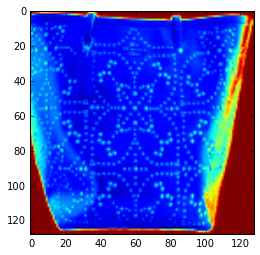

In [88]:
plt.imshow((tar_img[0]*255).astype('uint8'))

In [55]:
#somehow the order matter for me on minsky1, import torch stuff first
from skimage import color
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display



%matplotlib inline

In [58]:
tar_img

array([[[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]],

       [[1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        [1, 1, 1, ..., 1, 1, 1],
        ..., 
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0]]], dtype=uint8)

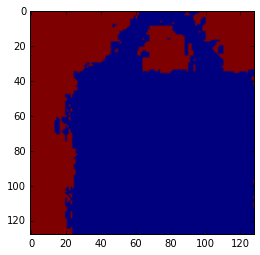

In [57]:
plt.imshow(tar_img[0])

In [35]:
def vis_image(img,color='lab'):
    
    if color == 'lab':
        ToRGB = transforms.toRGB()
        
    elif color =='rgb':
        ToRGB = transforms.toRGB('RGB')
        
    img_np = ToRGB(img)[0]
   
    
    return np.transpose(img_np.cpu().numpy(),(1,2,0))

In [19]:
vis_image((seg.cpu()))

lab
torch.Size([8, 3, 128, 128])


ValueError: axes don't match array

In [8]:
import torch
import numpy as np
from PIL import Image
import utils.transforms as transforms


In [77]:

def vis_patch(img,skg,xcenter=64,ycenter=64,size=40,color='lab'):
    if color == 'lab':
        ToRGB = transforms.toRGB()
        
    elif color =='rgb':
        ToRGB = transforms.toRGB('RGB')
        
    img_np = ToRGB(img)[0]
    skg_np = ToRGB(skg)[0]
    print np.shape(skg_np)
    
    vis_skg = np.copy(skg_np.cpu().numpy())
    vis_img = np.copy(img_np.cpu().numpy())
    print np.shape(vis_img)
    print xcenter, size, ycenter
    vis_skg[:,xcenter-size/2:xcenter+size/2,ycenter-size/2:ycenter+size/2] = vis_img[:,xcenter-size/2:xcenter+size/2,ycenter-size/2:ycenter+size/2]
    
    return np.transpose(vis_img,(1,2,0))


In [76]:
crop_size

25

In [78]:
test = vis_patch(utforms.denormalize_rgb(img.cpu()),utforms.denormalize_rgb(skg.cpu()),xcenter,ycenter,crop_size,args.color_space)

torch.Size([3, 128, 128])
(3, 128, 128)
43 25 101


In [79]:
np.shape(test)

(128, 128, 3)

In [17]:
img_=utforms.normalize_rgb(img)

In [19]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

In [18]:
img_


( 0 , 0 ,.,.) = 
  0.1083 -0.1314  0.2967  ...   1.2728  1.9749  0.4508
  0.1426 -0.1314  0.2796  ...   1.3927  1.9749  0.7077
  0.5193  1.5297  1.4783  ...   0.4851  0.7762  0.1426
           ...             ⋱             ...          
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489
  2.2489  2.2489  2.2489  ...   2.2489  2.2489  2.2489

( 0 , 1 ,.,.) = 
 -1.1429 -1.0553 -0.0399  ...   0.7654  1.5357 -0.3375
 -0.8803 -0.8452  0.0476  ...   0.8004  1.5357 -0.1975
 -0.2850  1.1856  1.3606  ...  -0.1450  0.2402 -0.8452
           ...             ⋱             ...          
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286
  2.4286  2.4286  2.4286  ...   2.4286  2.4286  2.4286

( 0 , 2 ,.,.) = 
 -0.9678 -0.8981 -0.0092  ...   0.8274  1.6117 -0.1835
 -0.7587 -0.7064  0.1128  ...   0.8448  1.5594 -0.0964
 -0.1835  1.2980  1.4897  ...  -0.1487  0.1999 -0.7761
           

In [16]:
img


( 0 , 0 ,.,.) = 
  0.5098  0.4549  0.5529  ...   0.7765  0.9373  0.5882
  0.5176  0.4549  0.5490  ...   0.8039  0.9373  0.6471
  0.6039  0.8353  0.8235  ...   0.5961  0.6627  0.5176
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

( 0 , 1 ,.,.) = 
  0.2000  0.2196  0.4471  ...   0.6275  0.8000  0.3804
  0.2588  0.2667  0.4667  ...   0.6353  0.8000  0.4118
  0.3922  0.7216  0.7608  ...   0.4235  0.5098  0.2667
           ...             ⋱             ...          
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000
  1.0000  1.0000  1.0000  ...   1.0000  1.0000  1.0000

( 0 , 2 ,.,.) = 
  0.1882  0.2039  0.4039  ...   0.5922  0.7686  0.3647
  0.2353  0.2471  0.4314  ...   0.5961  0.7569  0.3843
  0.3647  0.6980  0.7412  ...   0.3725  0.4510  0.2314
           

In [63]:
patchsize = 50
x = int( rand_between(patchsize,args.image_size-patchsize))
y = int( rand_between(patchsize,args.image_size-patchsize))

texture_patch = outputlll[:,:,x:(x+patchsize),y:(y+patchsize)]
texture_feat = Extract_content(test)[0]

In [64]:
texture_patch = outputlll[:,:,x:(x+patchsize),y:(y+patchsize)]

In [65]:
test2 = Extract_content(test)[0]

In [66]:
test2.size()

torch.Size([8, 256, 12, 12])

In [14]:
utforms.denormalize_lab(skg)


( 0 , 0 ,.,.) = 
  100  100  100  ...   100  100  100
  100  100  100  ...   100  100  100
  100  100  100  ...   100  100  100
      ...         ⋱        ...      
  100  100  100  ...   100  100  100
  100  100  100  ...   100  100  100
  100  100  100  ...   100  100  100

( 0 , 1 ,.,.) = 
 -128 -128 -128  ...  -128 -128 -128
 -128 -128 -128  ...  -128 -128 -128
 -128 -128 -128  ...  -128 -128 -128
      ...         ⋱        ...      
 -128 -128 -128  ...  -128 -128 -128
 -128 -128 -128  ...  -128 -128 -128
 -128 -128 -128  ...  -128 -128 -128

( 0 , 2 ,.,.) = 
  128  128  128  ...   128  128  128
  128  128  128  ...   128  128  128
  128  128  128  ...   128  128  128
      ...         ⋱        ...      
  128  128  128  ...   128  128  128
  128  128  128  ...   128  128  128
  128  128  128  ...   128  128  128
      ⋮  

( 1 , 0 ,.,.) = 
  100  100  100  ...   100  100  100
  100  100  100  ...   100  100  100
  100  100  100  ...   100  100  100
      ...         ⋱        ...

In [129]:
def rand_between(a,b):
    return a + torch.round(torch.rand(1)*(b-a))[0]
    

In [131]:
for i in range(100):
    test = rand_between(5,10)
    if test==10:
        print 'yay'

yay
yay
yay
yay
yay
yay
yay


In [140]:
crop_size = rand_between(args.crop_size_min, args.crop_size_max)
xcenter = rand_between(crop_size/2,args.image_size-crop_size/2)
ycenter = rand_between(crop_size/2,args.image_size-crop_size/2)

In [143]:
ycenter

56.0

In [71]:
torch.cat((outputl,outputl,outputl),1)

Variable containing:
( 0 , 0 ,.,.) = 
 -6.1151e-02 -5.0124e-02 -1.0696e-01  ...   1.9763e-03  5.0756e-02  1.7801e-02
  2.8003e-02 -7.6340e-02 -4.8401e-02  ...  -6.7431e-02 -1.0512e-02  2.5269e-02
 -8.4945e-02 -5.7028e-03  2.2068e-02  ...   5.9485e-02  4.8279e-04  1.2685e-02
                 ...                   ⋱                   ...                
  1.9536e-02  2.8663e-02  7.8787e-02  ...   4.1614e-02  8.6871e-02  8.7179e-02
  5.3318e-02  9.9141e-02  7.0438e-02  ...   4.5543e-02  1.0288e-01 -3.3481e-02
  4.6934e-02  5.6280e-02  9.8700e-02  ...   6.6231e-02  2.5655e-02 -1.1471e-02

( 0 , 1 ,.,.) = 
 -6.1151e-02 -5.0124e-02 -1.0696e-01  ...   1.9763e-03  5.0756e-02  1.7801e-02
  2.8003e-02 -7.6340e-02 -4.8401e-02  ...  -6.7431e-02 -1.0512e-02  2.5269e-02
 -8.4945e-02 -5.7028e-03  2.2068e-02  ...   5.9485e-02  4.8279e-04  1.2685e-02
                 ...                   ⋱                   ...                
  1.9536e-02  2.8663e-02  7.8787e-02  ...   4.1614e-02  8.6871e-02  8.7179e

In [72]:
targetlll

Variable containing:
( 0 , 0 ,.,.) = 
  1.8850e+00  1.8850e+00  1.8850e+00  ...   1.8850e+00  1.8850e+00  1.8850e+00
  1.8850e+00  1.8850e+00  1.8850e+00  ...   1.8850e+00  1.8850e+00  1.8850e+00
  1.8850e+00  1.8850e+00  1.8850e+00  ...   1.8850e+00  1.8850e+00  1.8850e+00
                 ...                   ⋱                   ...                
  1.7038e+00  1.7038e+00  1.7038e+00  ...   1.6402e+00  1.6530e+00  1.6503e+00
  1.7626e+00  1.7626e+00  1.7626e+00  ...   1.7119e+00  1.7065e+00  1.7065e+00
  1.7978e+00  1.7978e+00  1.7978e+00  ...   1.7725e+00  1.7572e+00  1.7572e+00

( 0 , 1 ,.,.) = 
  2.0565e+00  2.0565e+00  2.0565e+00  ...   2.0565e+00  2.0565e+00  2.0565e+00
  2.0565e+00  2.0565e+00  2.0565e+00  ...   2.0565e+00  2.0565e+00  2.0565e+00
  2.0565e+00  2.0565e+00  2.0565e+00  ...   2.0565e+00  2.0565e+00  2.0565e+00
                 ...                   ⋱                   ...                
  1.8713e+00  1.8713e+00  1.8713e+00  ...   1.8063e+00  1.8193e+00  1.8166e

In [65]:
targetlll[0].data.cpu()


( 0 ,.,.) = 
  1.8850e+00  1.8850e+00  1.8850e+00  ...   1.8850e+00  1.8850e+00  1.8850e+00
  1.8850e+00  1.8850e+00  1.8850e+00  ...   1.8850e+00  1.8850e+00  1.8850e+00
  1.8850e+00  1.8850e+00  1.8850e+00  ...   1.8850e+00  1.8850e+00  1.8850e+00
                 ...                   ⋱                   ...                
  1.7038e+00  1.7038e+00  1.7038e+00  ...   1.6402e+00  1.6530e+00  1.6503e+00
  1.7626e+00  1.7626e+00  1.7626e+00  ...   1.7119e+00  1.7065e+00  1.7065e+00
  1.7978e+00  1.7978e+00  1.7978e+00  ...   1.7725e+00  1.7572e+00  1.7572e+00

( 1 ,.,.) = 
  2.0565e+00  2.0565e+00  2.0565e+00  ...   2.0565e+00  2.0565e+00  2.0565e+00
  2.0565e+00  2.0565e+00  2.0565e+00  ...   2.0565e+00  2.0565e+00  2.0565e+00
  2.0565e+00  2.0565e+00  2.0565e+00  ...   2.0565e+00  2.0565e+00  2.0565e+00
                 ...                   ⋱                   ...                
  1.8713e+00  1.8713e+00  1.8713e+00  ...   1.8063e+00  1.8193e+00  1.8166e+00
  1.9314e+00  1.9314e+00

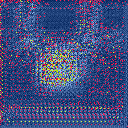

In [67]:
import torchvision.transforms
test = targetlll[0].data.cpu()
to_pil = torchvision.transforms.ToPILImage()
img_ = to_pil(test)
img_

In [29]:
img.clone()


( 0 , 0 ,.,.) = 
  8.3333e-01  8.3333e-01  8.3333e-01  ...   8.3333e-01  8.3333e-01  8.3333e-01
  8.3333e-01  8.3333e-01  8.3333e-01  ...   8.3333e-01  8.3333e-01  8.3333e-01
  8.3333e-01  8.3333e-01  8.3333e-01  ...   8.3333e-01  8.3333e-01  8.3333e-01
                 ...                   ⋱                   ...                
  8.3333e-01  8.3333e-01  8.3333e-01  ...   8.3333e-01  8.3333e-01  8.3333e-01
  8.3333e-01  8.3333e-01  8.3333e-01  ...   8.3333e-01  8.3333e-01  8.3333e-01
  8.3333e-01  8.3333e-01  8.3333e-01  ...   8.3333e-01  8.3333e-01  8.3333e-01

( 0 , 1 ,.,.) = 
 -1.5343e-05 -1.5343e-05 -1.5343e-05  ...  -1.5343e-05 -1.5343e-05 -1.5343e-05
 -1.5343e-05 -1.5343e-05 -1.5343e-05  ...  -1.5343e-05 -1.5343e-05 -1.5343e-05
 -1.5343e-05 -1.5343e-05 -1.5343e-05  ...  -1.5343e-05 -1.5343e-05 -1.5343e-05
                 ...                   ⋱                   ...                
 -1.5343e-05 -1.5343e-05 -1.5343e-05  ...  -1.5343e-05 -1.5343e-05 -1.5343e-05
 -1.5343e-05 -1.

In [22]:
def renormalize(img):
    '''
    Renormalizes the input image to meet requirements for VGG-19 pretrained network
    '''
    
    forward_norm = torch.ones(img.data.size())*0.5
    forward_norm = Variable(forward_norm.cuda())
    img=img*(forward_norm)+forward_norm #add previous norm 
    mean = img.data.new(img.data.size())
    std = img.data.new(img.data.size())
    mean[:, 0, :, :] = 0.485
    mean[:, 1, :, :] = 0.456
    mean[:, 2, :, :] = 0.406
    std[:, 0, :, :] = 0.229
    std[:, 1, :, :] = 0.224
    std[:, 2, :, :] = 0.225
    img -= Variable(mean)
    img = img / Variable(std)
    
    return img

In [60]:
target_img=vis_image(utforms.denormalize_lab(fake.data.double().cpu()))
target_img=(target_img*255).astype('uint8')

In [56]:
target_img=vis_image(utforms.denormalize_lab(img.cpu()))
target_img=(target_img*255).astype('uint8')
#target_img=np.transpose(target_img,(2,0,1))

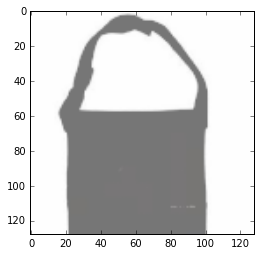

In [45]:
%matplotlib inline
plt.imshow(test)

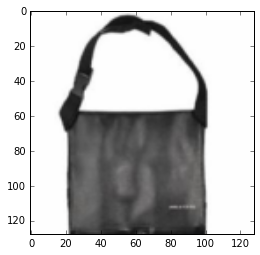

In [61]:
plt.imshow(target_img)

In [188]:
test2.size()

torch.Size([8, 1, 128, 128])

In [186]:
test1,test2 = torch.chunk((fake),2,dim=1)

In [246]:
netG

Scribbler (
  (model): Sequential (
    (res_block_1): ResidualBlock (
      (resblock): Sequential (
        (conv_1): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
        (norm_1): ReLU (inplace)
        (conv_2): Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (batch_2): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
      )
    )
  )
)

In [229]:
gram_y.size()

torch.Size([8, 64, 64])

In [216]:
output_feat_[m].size()

torch.Size([8, 64, 128, 128])

In [217]:
gram(output_feat_[m]).size()

torch.Size([512, 512])

In [205]:
gram(target_feat_[m]).size()

torch.Size([4096, 4096])

In [218]:
len(output_feat_)

6

In [208]:
test = [gram(y) for y in target_feat_]

In [209]:
test[0].size()

torch.Size([512, 512])

In [194]:
err_style

Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 1)]

In [170]:
def gen_input(img,skg,xcenter=64,ycenter=64,size=40):
    #generate input skg with random patch from img
    #input img,skg [bsx3xwxh], xcenter,ycenter, size 
    #output bsx5xwxh
       
    w,h = img.size()[2:4]

    xstart = max(xcenter-size/2,0)
    ystart = max(ycenter-size/2,0)
    xend = min(xcenter + size/2,w)
    yend = min(ycenter + size/2,h)


    input_texture = torch.zeros(img.size())
    input_sketch = skg[:,0:1,:,:] #L channel from skg
    input_mask = torch.zeros(input_sketch.size())

    input_mask[:,:,xstart:xend,ystart:yend] = 1
    input_texture[:,:,xstart:xend,ystart:yend] = img[:,:,xstart:xend,ystart:yend]

    return torch.cat((input_sketch.float(),input_texture,input_mask),1)
     

In [167]:
#################
xcenter = 0
ycenter = 0
size = 40

w,h = img.size()[2:4]

xstart = max(xcenter-size/2,0)
ystart = max(ycenter-size/2,0)
xend = min(xcenter + size/2,w)
yend = min(ycenter + size/2,h)


input_texture = torch.zeros(img.size())
input_sketch = skg[:,0:1,:,:] #L channel from skg
input_mask = torch.zeros(input_sketch.size())

input_mask[:,:,xstart:xend,ystart:yend] = 1
input_texture[:,:,xstart:xend,ystart:yend] = img[:,:,xstart:xend,ystart:yend]

results = torch.cat((input_sketch.float(),input_texture,input_mask),1)

#vis_img[xcenter-size/2:xcenter+size/2,ycenter-size/2:ycenter+size/2,:] = img_np[xcenter-size/2:xcenter+size/2,ycenter-size/2:ycenter+size/2,:]


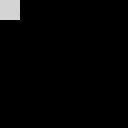

In [168]:
import torchvision.transforms
test = (results[0,1,:,:].expand(3,128,128))
to_pil = torchvision.transforms.ToPILImage()
img_ = to_pil(test)
img_

In [31]:
skg = torch.round(skg)


In [35]:
#L channel sketch
skg[:,0:1,:,:]

#LAB channel patch
patch = gen_input()

torch.Size([8, 1, 128, 128])

In [30]:
test

array([[[ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        ..., 
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999]],

       [[ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        ..., 
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999]],

       [[ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        ..., 
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999],
        [ 0.99999999,  0.99999999,  0.99999999]],

       ..., 
       [[ 0.99999999,  0.99999999,  0.99999999],
        

In [37]:
np.shape(np.transpose(test,(2,0,1)))

(3, 128, 128)

In [40]:
aaa = np.array(np.transpose(test,(2,0,1)))

In [17]:
utforms.denormalize_lab(test_img)


( 0 , 0 ,.,.) = 
  1.0000e+02  1.0000e+02  1.0000e+02  ...   1.0000e+02  1.0000e+02  1.0000e+02
  1.0000e+02  1.0000e+02  1.0000e+02  ...   1.0000e+02  1.0000e+02  1.0000e+02
  1.0000e+02  1.0000e+02  1.0000e+02  ...   1.0000e+02  1.0000e+02  1.0000e+02
                 ...                   ⋱                   ...                
  1.0000e+02  1.0000e+02  1.0000e+02  ...   1.0000e+02  1.0000e+02  1.0000e+02
  1.0000e+02  1.0000e+02  1.0000e+02  ...   1.0000e+02  1.0000e+02  1.0000e+02
  1.0000e+02  1.0000e+02  1.0000e+02  ...   1.0000e+02  1.0000e+02  1.0000e+02

( 0 , 1 ,.,.) = 
 -2.4549e-03 -2.4549e-03 -2.4549e-03  ...  -2.4549e-03 -2.4549e-03 -2.4549e-03
 -2.4549e-03 -2.4549e-03 -2.4549e-03  ...  -2.4549e-03 -2.4549e-03 -2.4549e-03
 -2.4549e-03 -2.4549e-03 -2.4549e-03  ...  -2.4549e-03 -2.4549e-03 -2.4549e-03
                 ...                   ⋱                   ...                
 -2.4549e-03 -2.4549e-03 -2.4549e-03  ...  -2.4549e-03 -2.4549e-03 -2.4549e-03
 -2.4549e-03 -2.

In [16]:
test_img=clamp_image(fake.data.double().cpu())
test_img


( 0 , 0 ,.,.) = 
  0.8333  0.8333  0.8333  ...   0.8333  0.8333  0.8333
  0.8333  0.8333  0.8333  ...   0.8333  0.8333  0.8333
  0.8333  0.8333  0.8333  ...   0.8333  0.8333  0.8333
           ...             ⋱             ...          
  0.8333  0.8333  0.8333  ...   0.8333  0.8333  0.8333
  0.8333  0.8333  0.8333  ...   0.8333  0.8333  0.8333
  0.8333  0.8333  0.8333  ...   0.8333  0.8333  0.8333

( 0 , 1 ,.,.) = 
 -0.0000 -0.0000 -0.0000  ...  -0.0000 -0.0000 -0.0000
 -0.0000 -0.0000 -0.0000  ...  -0.0000 -0.0000 -0.0000
 -0.0000 -0.0000 -0.0000  ...  -0.0000 -0.0000 -0.0000
           ...             ⋱             ...          
 -0.0000 -0.0000 -0.0000  ...  -0.0000 -0.0000 -0.0000
 -0.0000 -0.0000 -0.0000  ...  -0.0000 -0.0000 -0.0000
 -0.0000 -0.0000 -0.0000  ...  -0.0000 -0.0000 -0.0000

( 0 , 2 ,.,.) = 
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
  0.0000  0.0000  0.0000  ...   0.0000  0.0000  0.0000
           

In [7]:
scribbler.Scribbler(3,3,32)

Scribbler (
  (model): Sequential (
  )
)

In [7]:
class GramMatrix(nn.Module):

    def forward(self, input):
        a, b, c, d = input.size()  # a=batch size(=1)
        # b=number of feature maps
        # (c,d)=dimensions of a f. map (N=c*d)

        features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL
        #ignore batch transpose
        G = torch.bmm(features, features.t(1,2))  # compute the gram product

        # normalize the values of the gram matrix
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)

In [8]:
class FeatureExtractor(nn.Module):
    # Extract features from intermediate layers of a network

    def __init__(self, submodule, extracted_layers):
        super(FeatureExtractor,self).__init__()
        self.submodule = submodule
        self.extracted_layers=extracted_layers

    def forward(self, x):
        outputs = []
        for name, module in self.submodule._modules.items():
            x = module(x)
            if name in self.extracted_layers:
                outputs += [x]
        return outputs + [x]

In [9]:
def renormalize(lab_img):
    """
    Normalizes the LAB image to lie in range 0-1
    
    Args:
    lab_img : torch.Tensor img in lab space
    
    Returns:
    lab_img : torch.Tensor Normalized lab_img 
    """
    mean = torch.zeros(lab_img.size())
    stds = torch.zeros(lab_img.size())
    
    mean[:,0,:,:] = -0.5+0.485
    mean[:,1,:,:] = -0.5+0.456
    mean[:,2,:,:] = -0.5+0.406
    
    stds[:,0,:,:] = 0.229
    stds[:,1,:,:] = 0.224
    stds[:,2,:,:] = 0.225
    
    return (lab_img - mean)/stds


In [21]:
test = transforms.Compose([renormalize])
a=test(fake)

RuntimeError: in-place operations can be only used on variables that don't share storage with any other variables, but detected that there are 3 objects sharing it

In [10]:
def save_network(model, network_label, epoch_label, gpu_id, save_dir):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, save_filename)
    torch.save(model.cpu().state_dict(), save_path)
    model.cuda(device_id=gpu_id)
def load_network(model, network_label, epoch_label,save_dir):
    save_filename = '%s_net_%s.pth' % (epoch_label, network_label)
    save_path = os.path.join(save_dir, save_filename)
    model.load_state_dict(torch.load(save_path))

In [35]:
#TODO normalize and minus mean
feat_model=models.vgg19(pretrained=True)
lab_var = fake
L,A,B=torch.chunk(lab_var,3,dim=1)
LLL=torch.cat((L,L,L),1)
out=feat_model.features(LLL)

RuntimeError: tensors are on different GPUs

In [81]:
import torchvision.transforms
from __future__ import division
import torch
import math
import random
from PIL import Image, ImageOps
try:
    import accimage
except ImportError:
    accimage = None
import numpy as np
import numbers
import types
import collections

In [124]:

class Compose(object):
    """Composes several transforms together.
    Args:
        transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
        >>> transforms.Compose([
        >>>     transforms.CenterCrop(10),
        >>>     transforms.ToTensor(),
        >>> ])
    """

    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, imgs):
        for t in self.transforms:
            imgs = t(imgs)
        return imgs

class Scale(object):
    """Rescale multiple input PIL.Image to the given size.
    Args:
        size (sequence or int): Desired output size. If size is a sequence like
            (w, h), output size will be matched to this. If size is an int,
            smaller edge of the image will be matched to this number.
            i.e, if height > width, then image will be rescaled to
            (size * height / width, size)
        interpolation (int, optional): Desired interpolation. Default is
            ``PIL.Image.BILINEAR``
    """

    def __init__(self, size, interpolation=Image.BILINEAR):
        assert isinstance(size, int) or (isinstance(size, collections.Iterable) and len(size) == 2)
        self.size = size
        self.interpolation = interpolation
        self.transform = torchvision.transforms.Scale(size)

    def __call__(self, imgs):
        """
        Args:
            imgs (list of PIL.Image): Images to be scaled.
        Returns:
            list of PIL.Image: Rescaled images.
        """
        results = []
        #w,h = imgs[0].size
        for img in imgs:
            if isinstance(self.size, int):
                #ww, hh = img.size
                
                #img,skg,seg have to all have the same size
                #assert w==ww, 'inconsistent image size'
                #assert h==hh, 'inconsistent image size'
                
                results.append(self.transform(img))
                
        return [self.transform(img) for img in imgs]

class CenterCrop(object):
    """Crops the given PIL.Image at the center.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
    """

    def __init__(self, size):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.transform = torchvision.transforms.CenterCrop(size)

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        return [self.transform(img) for img in imgs]
    
class Pad(object):
    """Pad the given PIL.Image on all sides with the given "pad" value.
    Args:
        padding (int or tuple): Padding on each border. If a single int is provided this
            is used to pad all borders. If tuple of length 2 is provided this is the padding
            on left/right and top/bottom respectively. If a tuple of length 4 is provided
            this is the padding for the left, top, right and bottom borders
            respectively.
        fill: Pixel fill value. Default is 0. If a tuple of
            length 3, it is used to fill R, G, B channels respectively.
    """

    def __init__(self, padding, fill=0):
        assert isinstance(padding, (numbers.Number, tuple))
        assert isinstance(fill, (numbers.Number, str, tuple))
        if isinstance(padding, collections.Sequence) and len(padding) not in [2, 4]:
            raise ValueError("Padding must be an int or a 2, or 4 element tuple, not a " +
                             "{} element tuple".format(len(padding)))

        self.padding = padding
        self.fill = fill
        
        self.transform = torchvision.transforms.Pad(padding,fill)

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be padded.
        Returns:
            PIL.Image: Padded image.
        """
        
        return [self.transform(img) for img in imgs]

class RandomCrop(object):
    """Crop the given PIL.Image at a random location.
    Args:
        size (sequence or int): Desired output size of the crop. If size is an
            int instead of sequence like (h, w), a square crop (size, size) is
            made.
        padding (int or sequence, optional): Optional padding on each border
            of the image. Default is 0, i.e no padding. If a sequence of length
            4 is provided, it is used to pad left, top, right, bottom borders
            respectively.
    """

    def __init__(self, size, padding=0):
        if isinstance(size, numbers.Number):
            self.size = (int(size), int(size))
        else:
            self.size = size
        self.padding = padding

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be cropped.
        Returns:
            PIL.Image: Cropped image.
        """
        if self.padding > 0:
            imgs = [ImageOps.expand(img, border=self.padding, fill=0) for img in imgs]

        w, h = imgs[0].size
        th, tw = self.size
        if w == tw and h == th:
            return imgs

        x1 = random.randint(0, w - tw)
        y1 = random.randint(0, h - th)
        return [img.crop((x1, y1, x1 + tw, y1 + th)) for img in imgs]

class RandomHorizontalFlip(object):
    """Horizontally flip the given PIL.Image randomly with a probability of 0.5."""

    def __call__(self, imgs):
        """
        Args:
            img (PIL.Image): Image to be flipped.
        Returns:
            PIL.Image: Randomly flipped image.
        """
        if random.random() < 0.5:
            return [img.transpose(Image.FLIP_LEFT_RIGHT) for img in imgs]
        return imgs

class RandomSizedCrop(object):
    """Crop the given PIL.Image to random size and aspect ratio.
    A crop of random size of (0.08 to 1.0) of the original size and a random
    aspect ratio of 3/4 to 4/3 of the original aspect ratio is made. This crop
    is finally resized to given size.
    This is popularly used to train the Inception networks.
    Args:
        size: size of the smaller edge
        interpolation: Default: PIL.Image.BILINEAR
    """

    def __init__(self, size, min_resize=0.08,max_resize=1.0,interpolation=Image.BILINEAR):
        self.size = size
        self.interpolation = interpolation
        self.resize_size = (min_resize,max_resize)

    def __call__(self, imgs):
        for attempt in range(10):
            area = imgs[0].size[0] * imgs[0].size[1]
            target_area = random.uniform(self.resize_size[0], self.resize_size[1]) * area
            aspect_ratio = random.uniform(3. / 4, 4. / 3)

            w = int(round(math.sqrt(target_area * aspect_ratio)))
            h = int(round(math.sqrt(target_area / aspect_ratio)))

            if random.random() < 0.5:
                w, h = h, w

            if w <= imgs[0].size[0] and h <= imgs[0].size[1]:
                x1 = random.randint(0, imgs[0].size[0] - w)
                y1 = random.randint(0, imgs[0].size[1] - h)

                imgs = [img.crop((x1, y1, x1 + w, y1 + h)) for img in imgs]
                assert([img.size == (w, h) for img in imgs])

                return [img.resize((self.size, self.size), self.interpolation) for img in imgs]

        # Fallback
        scale = Scale(self.size, interpolation=self.interpolation)
        crop = CenterCrop(self.size)
        return crop(scale(imgs))

    

In [17]:
renormalize(img)


( 0 , 0 ,.,.) = 
  3.7045e+00  3.7045e+00  3.7045e+00  ...   3.7045e+00  3.7045e+00  3.7045e+00
  3.7045e+00  3.7045e+00  3.7045e+00  ...   3.7045e+00  3.7045e+00  3.7045e+00
  3.7045e+00  3.7045e+00  3.7045e+00  ...   3.7045e+00  3.7045e+00  3.7045e+00
                 ...                   ⋱                   ...                
  3.7045e+00  3.7045e+00  3.7045e+00  ...   3.7045e+00  3.7045e+00  3.7045e+00
  3.7045e+00  3.7045e+00  3.7045e+00  ...   3.7045e+00  3.7045e+00  3.7045e+00
  3.7045e+00  3.7045e+00  3.7045e+00  ...   3.7045e+00  3.7045e+00  3.7045e+00

( 0 , 1 ,.,.) = 
  6.5435e-02  6.5435e-02  6.5435e-02  ...   6.5435e-02  6.5435e-02  6.5435e-02
  6.5435e-02  6.5435e-02  6.5435e-02  ...   6.5435e-02  6.5435e-02  6.5435e-02
  6.5435e-02  6.5435e-02  6.5435e-02  ...   6.5435e-02  6.5435e-02  6.5435e-02
                 ...                   ⋱                   ...                
  6.5435e-02  6.5435e-02  6.5435e-02  ...   6.5435e-02  6.5435e-02  6.5435e-02
  6.5435e-02  6.

In [125]:
tf = Compose([RandomSizedCrop(224,0.5,1),RandomHorizontalFlip()])
output = tf(images)

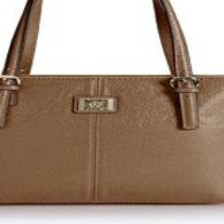

In [127]:
output[0]

In [33]:
images = []
img_dir = '/home/psangkloy3/training_handbags_pretrain/'
suffix = 'wendy/100_AB.jpg'
paths = [img_dir+p+suffix for p in ['val_img/','val_skg/','val_seg/']]
for path in paths:
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            images.append(img.convert('RGB'))
            

In [43]:
import glob
def make_dataset(dir):
    train_img=glob.glob(dir+'val_img/wendy/*.jpg')
    train_img=sorted(train_img)
    train_skg=glob.glob(dir+'val_skg/wendy/*.jpg')
    train_skg=sorted(train_skg)
    train_seg=glob.glob(dir+'val_seg/wendy/*.jpg')
    train_seg=sorted(train_seg)
    
    return zip(train_img,train_skg,train_seg)


In [44]:
test = make_dataset(img_dir)

In [47]:
def pil_loader(path):
    # open path as file to avoid ResourceWarning (https://github.com/python-pillow/Pillow/issues/835)
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')

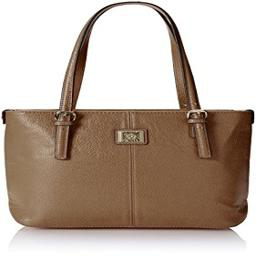

In [56]:
images[0]

(256, 256)